# Task 1: Preprocess and Explore Financial Data

This notebook covers:
- Loading historical financial data using YFinance for TSLA, BND, and SPY
- Data cleaning and preprocessing
- Exploratory Data Analysis (EDA)
- Statistical tests for stationarity
- Volatility analysis
- Risk metrics calculation

## Stocks to Analyze:
- **TSLA**: High returns with high volatility
- **BND**: Stability and low risk (bond ETF)
- **SPY**: Diversified, moderate-risk market exposure (S&P 500 ETF)
---

In [1]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading Function

In [2]:
def load_stock_data(tickers, start_date='2015-07-01', end_date='2025-07-31'):
    """
    Load historical stock data for given tickers

    Parameters:
    tickers (list): List of stock tickers
    start_date (str): Start date for data collection
    end_date (str): End date for data collection

    Returns:
    dict: Dictionary with ticker as key and DataFrame as value
    """
    stock_data = {}

    for ticker in tickers:
        try:
            print(f"Loading data for {ticker}...")
            stock = yf.Ticker(ticker)
            data = stock.history(start=start_date, end=end_date)

            if not data.empty:
                stock_data[ticker] = data
                print(f"✓ {ticker}: {len(data)} records loaded")
            else:
                print(f"✗ {ticker}: No data available")

        except Exception as e:
            print(f"✗ Error loading {ticker}: {str(e)}")

    return stock_data

# Define tickers and load data
tickers = ['TSLA', 'BND', 'SPY']
print("Loading historical financial data...")
stock_data = load_stock_data(tickers)
print(f"\nData loading complete. Loaded {len(stock_data)} tickers.")

Loading historical financial data...
Loading data for TSLA...
✓ TSLA: 2535 records loaded
Loading data for BND...
✓ BND: 2535 records loaded
Loading data for SPY...
✓ SPY: 2535 records loaded

Data loading complete. Loaded 3 tickers.


## 2. Data Overview and Basic Statistics

In [3]:
# Display basic information about each stock
for ticker, data in stock_data.items():
    print(f"\n{'='*50}")
    print(f"STOCK: {ticker}")
    print(f"{'='*50}")
    
    print(f"Data shape: {data.shape}")
    print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Columns: {list(data.columns)}")
    
    print("\nFirst 5 rows:")
    print(data.head())
    
    print("\nLast 5 rows:")
    print(data.tail())
    
    print("\nData types:")
    print(data.dtypes)
    
    print("\nMissing values:")
    print(data.isnull().sum())
    
    print("\nBasic statistics:")
    print(data.describe())


STOCK: TSLA
Data shape: (2535, 7)
Date range: 2015-07-01 to 2025-07-30
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

First 5 rows:
                                Open       High        Low      Close  \
Date                                                                    
2015-07-01 00:00:00-04:00  18.073999  18.174667  17.856667  17.943333   
2015-07-02 00:00:00-04:00  18.680000  18.830000  18.220667  18.667999   
2015-07-06 00:00:00-04:00  18.591999  18.779333  18.420000  18.648001   
2015-07-07 00:00:00-04:00  18.333332  18.346666  17.384666  17.858667   
2015-07-08 00:00:00-04:00  17.288000  17.386667  16.954000  16.997334   

                              Volume  Dividends  Stock Splits  
Date                                                           
2015-07-01 00:00:00-04:00   31518000        0.0           0.0  
2015-07-02 00:00:00-04:00  107458500        0.0           0.0  
2015-07-06 00:00:00-04:00   61828500        0.0           0.0  


## 3. Data Cleaning and Preprocessing

In [4]:
def clean_stock_data(stock_data):
    """
    Clean and preprocess stock data
    
    Parameters:
    stock_data (dict): Dictionary of stock DataFrames
    
    Returns:
    dict: Cleaned stock data
    """
    cleaned_data = {}
    
    for ticker, data in stock_data.items():
        print(f"\nCleaning data for {ticker}...")
        
        # Create a copy to avoid modifying original data
        cleaned = data.copy()
        
        # Check for missing values
        missing_before = cleaned.isnull().sum().sum()
        print(f"Missing values before cleaning: {missing_before}")
        
        # Forward fill missing values (use previous day's data)
        cleaned = cleaned.fillna(method='ffill')
        
        # Backward fill any remaining missing values at the beginning
        cleaned = cleaned.fillna(method='bfill')
        
        # Check for any remaining missing values
        missing_after = cleaned.isnull().sum().sum()
        print(f"Missing values after cleaning: {missing_after}")
        
        # Ensure all numeric columns are float
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_columns:
            if col in cleaned.columns:
                cleaned[col] = pd.to_numeric(cleaned[col], errors='coerce')
        
        # Remove any rows with NaN values (should be none after cleaning)
        cleaned = cleaned.dropna()
        
        print(f"Final data shape: {cleaned.shape}")
        
        cleaned_data[ticker] = cleaned
    
    return cleaned_data

# Clean the data
cleaned_stock_data = clean_stock_data(stock_data)


Cleaning data for TSLA...
Missing values before cleaning: 0
Missing values after cleaning: 0
Final data shape: (2535, 7)

Cleaning data for BND...
Missing values before cleaning: 0
Missing values after cleaning: 0
Final data shape: (2535, 8)

Cleaning data for SPY...
Missing values before cleaning: 0
Missing values after cleaning: 0
Final data shape: (2535, 8)


## 4. Calculate Daily Returns and Volatility

In [5]:
def calculate_returns_and_volatility(stock_data):
    """
    Calculate daily returns and volatility metrics
    
    Parameters:
    stock_data (dict): Dictionary of cleaned stock DataFrames
    
    Returns:
    dict: Stock data with additional metrics
    """
    enhanced_data = {}
    
    for ticker, data in stock_data.items():
        print(f"\nCalculating metrics for {ticker}...")
        
        # Create a copy
        enhanced = data.copy()
        
        # Calculate daily returns
        enhanced['Daily_Return'] = enhanced['Close'].pct_change()
        
        # Calculate log returns (better for statistical analysis)
        enhanced['Log_Return'] = np.log(enhanced['Close'] / enhanced['Close'].shift(1))
        
        # Calculate volatility (rolling standard deviation of returns)
        enhanced['Volatility_20d'] = enhanced['Daily_Return'].rolling(window=20).std() * np.sqrt(252)  # Annualized
        enhanced['Volatility_60d'] = enhanced['Daily_Return'].rolling(window=60).std() * np.sqrt(252)  # Annualized
        
        # Calculate rolling means
        enhanced['Rolling_Mean_20d'] = enhanced['Close'].rolling(window=20).mean()
        enhanced['Rolling_Mean_60d'] = enhanced['Close'].rolling(window=60).mean()
        
        # Calculate rolling standard deviation of prices
        enhanced['Price_Std_20d'] = enhanced['Close'].rolling(window=20).std()
        enhanced['Price_Std_60d'] = enhanced['Close'].rolling(window=60).std()
        
        # Remove first row (NaN due to pct_change)
        enhanced = enhanced.dropna()
        
        print(f"Enhanced data shape: {enhanced.shape}")
        print(f"Date range: {enhanced.index[0].strftime('%Y-%m-%d')} to {enhanced.index[-1].strftime('%Y-%m-%d')}")
        
        enhanced_data[ticker] = enhanced
    
    return enhanced_data

# Calculate returns and volatility
enhanced_stock_data = calculate_returns_and_volatility(cleaned_stock_data)


Calculating metrics for TSLA...
Enhanced data shape: (2475, 15)
Date range: 2015-09-25 to 2025-07-30

Calculating metrics for BND...
Enhanced data shape: (2475, 16)
Date range: 2015-09-25 to 2025-07-30

Calculating metrics for SPY...
Enhanced data shape: (2475, 16)
Date range: 2015-09-25 to 2025-07-30


## 5. Basic Statistics Analysis

In [6]:
# Analyze basic statistics for each stock
for ticker, data in enhanced_stock_data.items():
    print(f"\n{'='*60}")
    print(f"DETAILED STATISTICS FOR {ticker}")
    print(f"{'='*60}")
    
    # Price statistics
    print("\nPRICE STATISTICS:")
    print(f"Starting price: ${data['Close'].iloc[0]:.2f}")
    print(f"Ending price: ${data['Close'].iloc[-1]:.2f}")
    print(f"Total return: {((data['Close'].iloc[-1] / data['Close'].iloc[0]) - 1) * 100:.2f}%")
    print(f"Highest price: ${data['High'].max():.2f}")
    print(f"Lowest price: ${data['Low'].min():.2f}")
    
    # Return statistics
    print("\nRETURN STATISTICS:")
    print(f"Mean daily return: {data['Daily_Return'].mean() * 100:.4f}%")
    print(f"Median daily return: {data['Daily_Return'].median() * 100:.4f}%")
    print(f"Standard deviation of returns: {data['Daily_Return'].std() * 100:.4f}%")
    print(f"Annualized volatility: {data['Daily_Return'].std() * np.sqrt(252) * 100:.2f}%")
    
    # Volatility statistics
    print("\nVOLATILITY STATISTICS:")
    print(f"Mean 20-day volatility: {data['Volatility_20d'].mean() * 100:.2f}%")
    print(f"Mean 60-day volatility: {data['Volatility_20d'].mean() * 100:.2f}%")
    
    # Volume statistics
    if 'Volume' in data.columns:
        print("\nVOLUME STATISTICS:")
        print(f"Mean daily volume: {data['Volume'].mean():,.0f}")
        print(f"Median daily volume: {data['Volume'].median():,.0f}")


DETAILED STATISTICS FOR TSLA

PRICE STATISTICS:
Starting price: $17.13
Ending price: $319.04
Total return: 1762.75%
Highest price: $488.54
Lowest price: $9.40

RETURN STATISTICS:
Mean daily return: 0.1871%
Median daily return: 0.1258%
Standard deviation of returns: 3.7457%
Annualized volatility: 59.46%

VOLATILITY STATISTICS:
Mean 20-day volatility: 54.66%
Mean 60-day volatility: 54.66%

VOLUME STATISTICS:
Mean daily volume: 115,381,368
Median daily volume: 96,642,200

DETAILED STATISTICS FOR BND

PRICE STATISTICS:
Starting price: $61.52
Ending price: $72.95
Total return: 18.57%
Highest price: $77.41
Lowest price: $61.20

RETURN STATISTICS:
Mean daily return: 0.0074%
Median daily return: 0.0127%
Standard deviation of returns: 0.3483%
Annualized volatility: 5.53%

VOLATILITY STATISTICS:
Mean 20-day volatility: 4.58%
Mean 60-day volatility: 4.58%

VOLUME STATISTICS:
Mean daily volume: 4,495,811
Median daily volume: 4,186,700

DETAILED STATISTICS FOR SPY

PRICE STATISTICS:
Starting price

## 6. Visualize Closing Prices Over Time

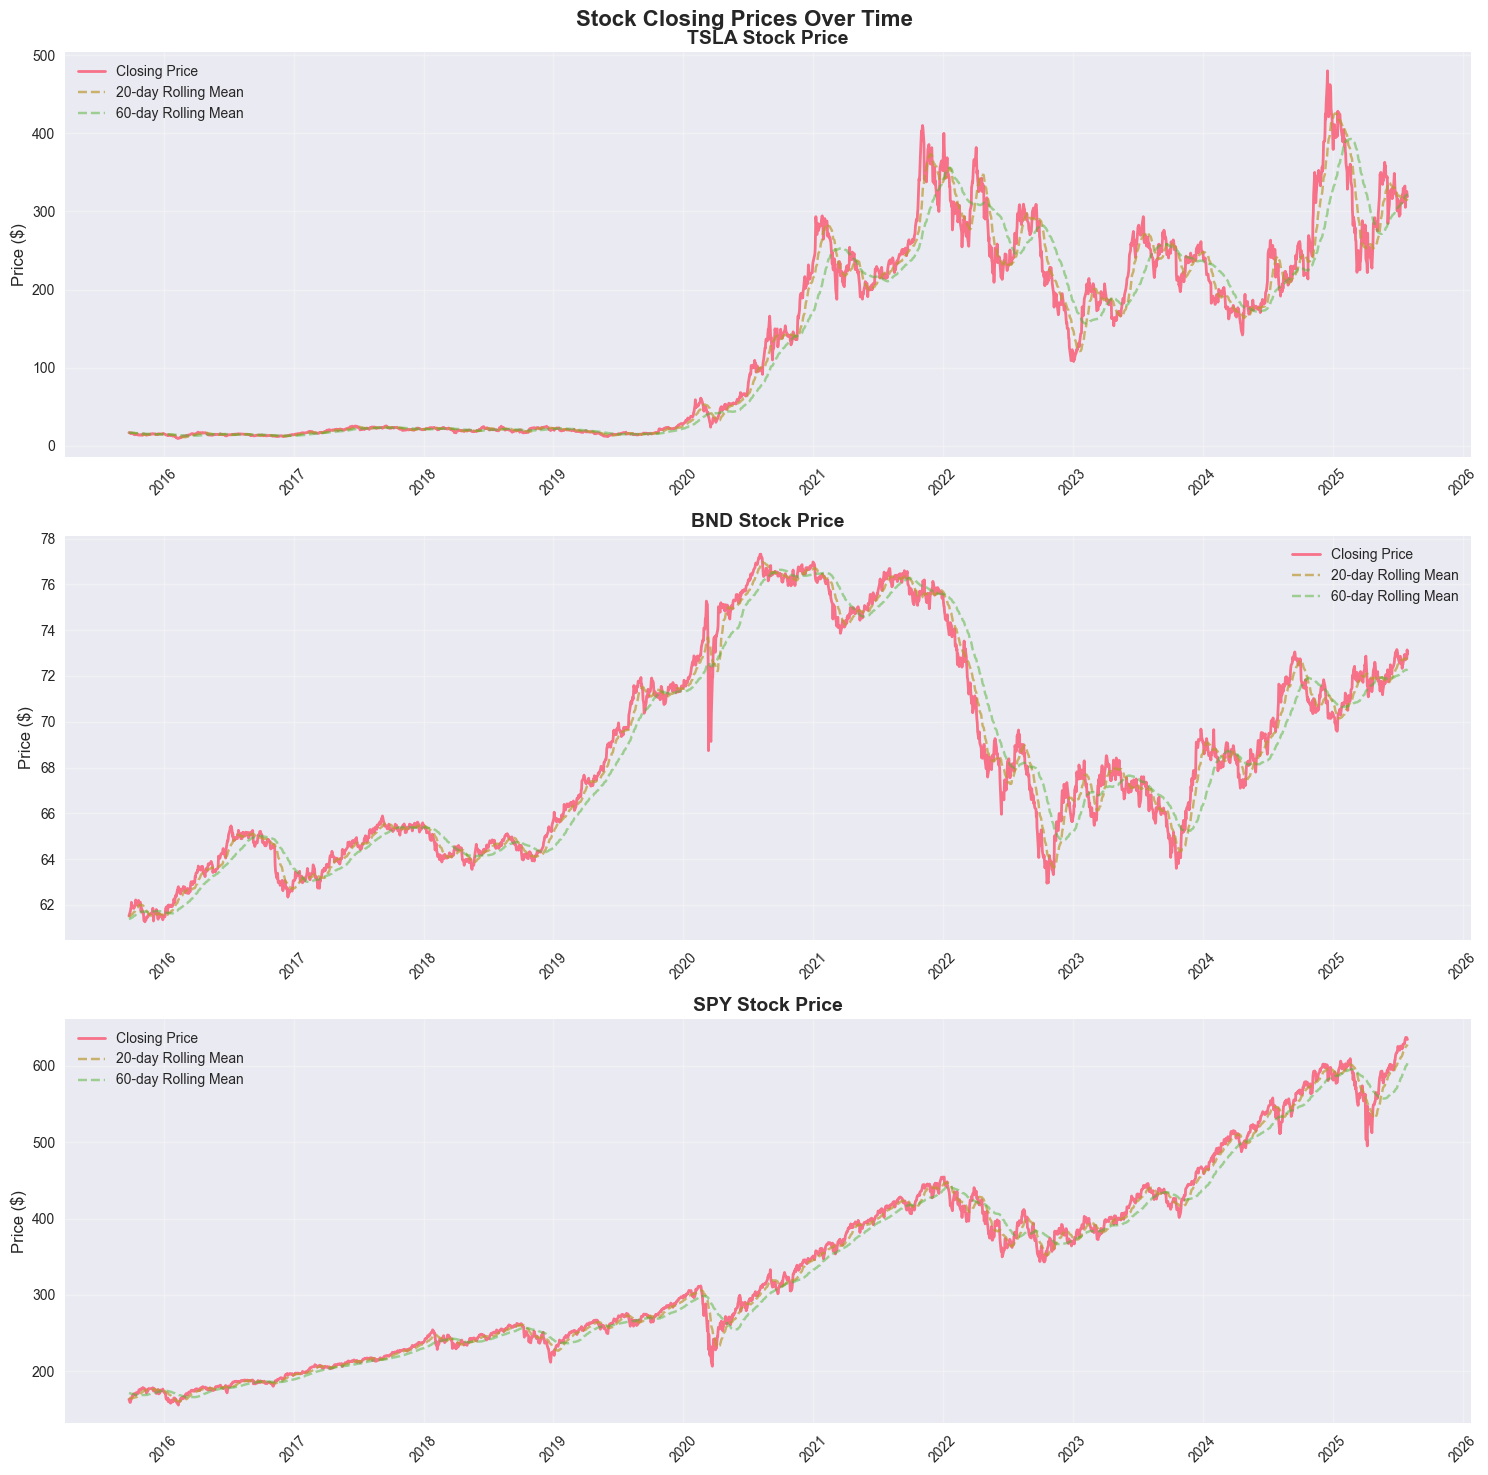

In [7]:
# Create subplots for closing prices
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle('Stock Closing Prices Over Time', fontsize=16, fontweight='bold')

for i, (ticker, data) in enumerate(enhanced_stock_data.items()):
    axes[i].plot(data.index, data['Close'], linewidth=2, label='Closing Price')
    axes[i].plot(data.index, data['Rolling_Mean_20d'], '--', alpha=0.7, label='20-day Rolling Mean')
    axes[i].plot(data.index, data['Rolling_Mean_60d'], '--', alpha=0.5, label='60-day Rolling Mean')
    
    axes[i].set_title(f'{ticker} Stock Price', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Price ($)', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Format x-axis
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Interactive plot using Plotly
fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=[f'{ticker} Stock Price' for ticker in enhanced_stock_data.keys()],
                    vertical_spacing=0.08)

for i, (ticker, data) in enumerate(enhanced_stock_data.items(), 1):
    fig.add_trace(
        go.Scatter(x=data.index, y=data['Close'], name=f'{ticker} Close', line=dict(width=2)),
        row=i, col=1
    )
    fig.add_trace(
        go.Scatter(x=data.index, y=data['Rolling_Mean_20d'], name=f'{ticker} 20d MA', 
                  line=dict(dash='dash', width=1)),
        row=i, col=1
    )

fig.update_layout(height=900, title_text="Stock Prices with Moving Averages", showlegend=True)
fig.show()

## 7. Daily Returns Analysis

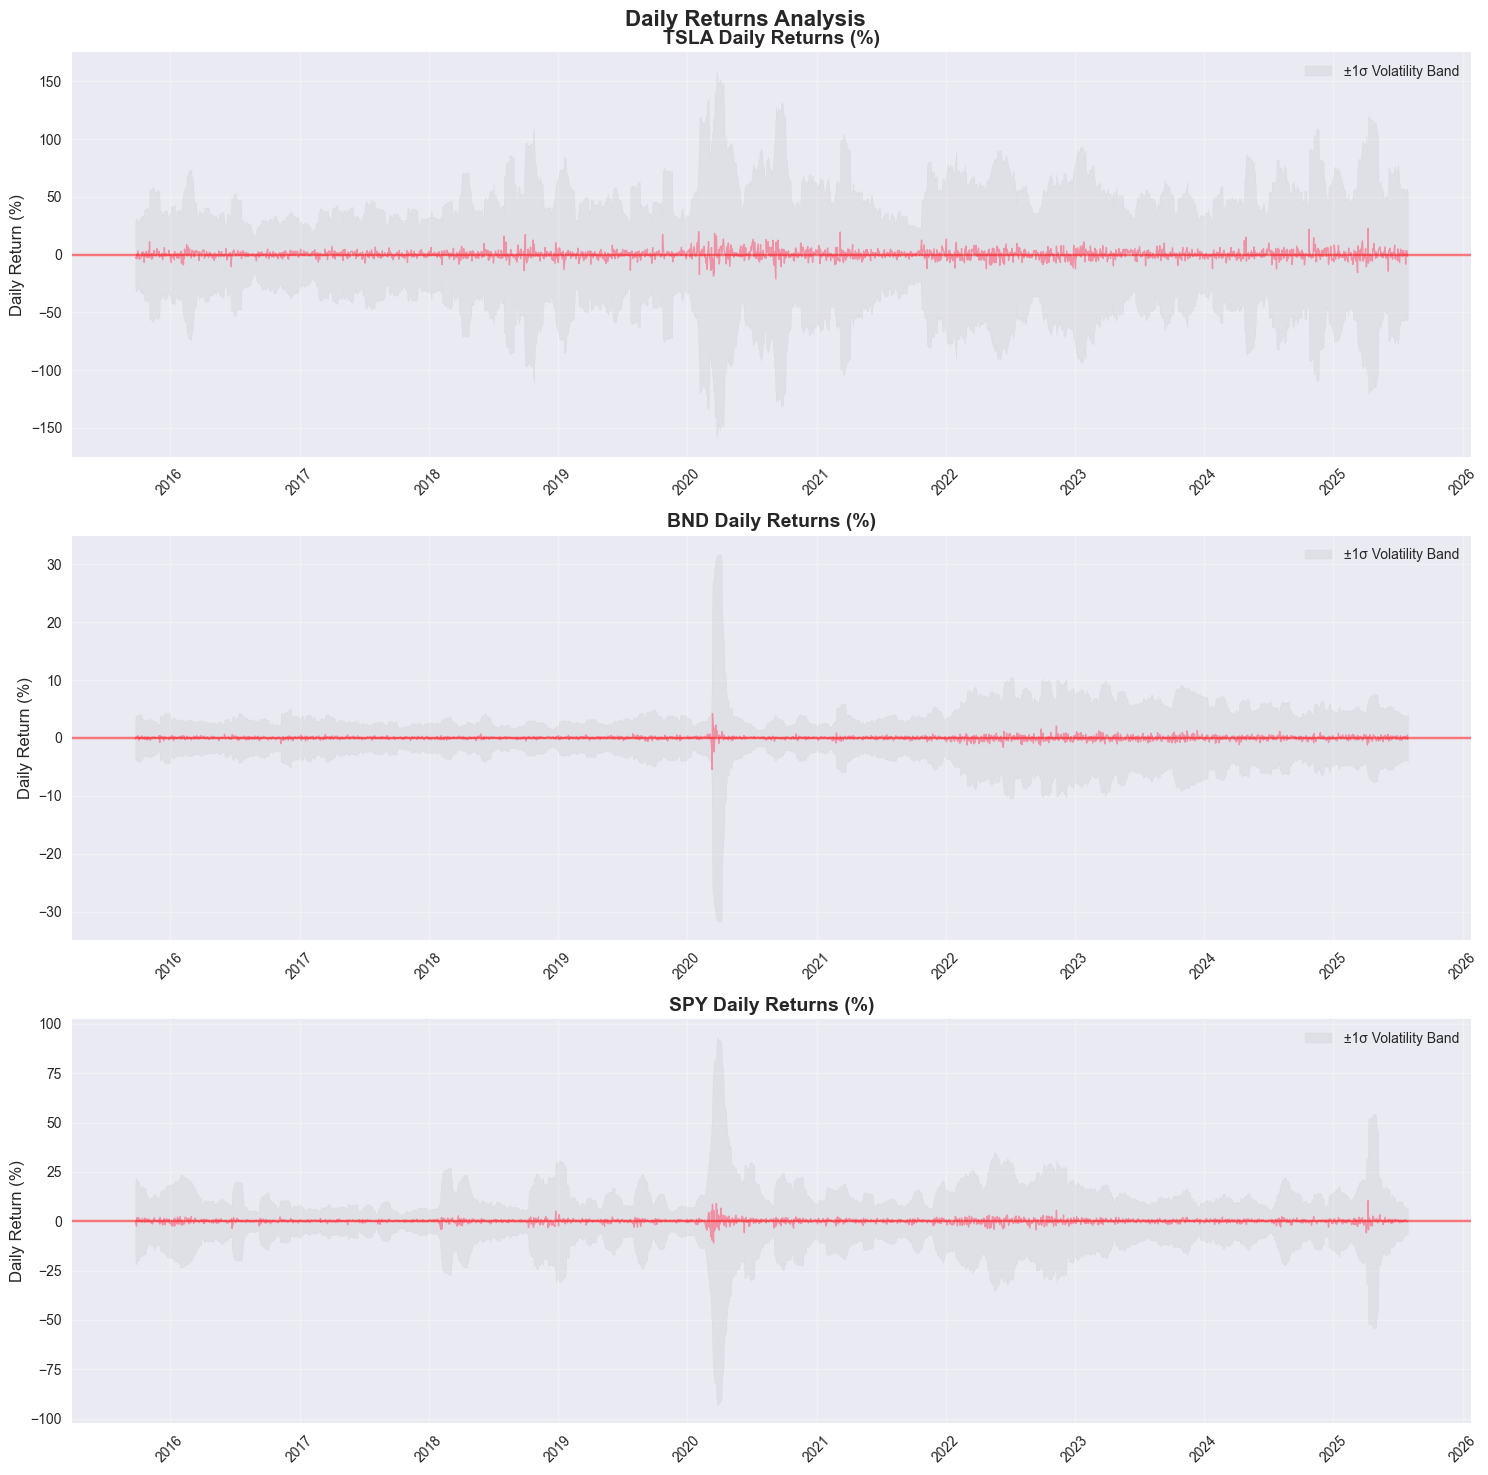

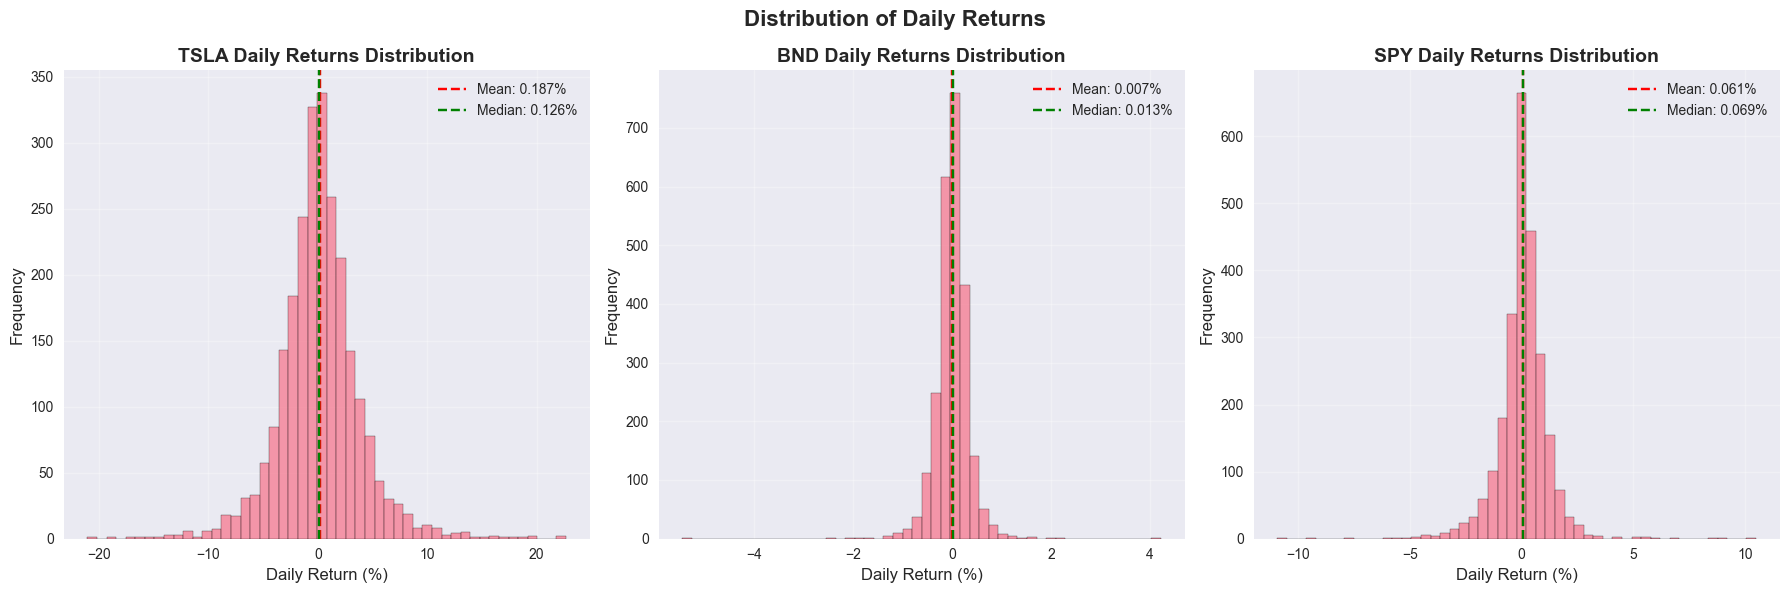

In [8]:
# Visualize daily returns
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle('Daily Returns Analysis', fontsize=16, fontweight='bold')

for i, (ticker, data) in enumerate(enhanced_stock_data.items()):
    # Daily returns
    axes[i].plot(data.index, data['Daily_Return'] * 100, alpha=0.7, linewidth=1)
    axes[i].axhline(y=0, color='red', linestyle='-', alpha=0.5)
    
    # Add rolling volatility bands
    axes[i].fill_between(data.index, 
                         -data['Volatility_20d'] * 100, 
                         data['Volatility_20d'] * 100, 
                         alpha=0.1, color='gray', label='±1σ Volatility Band')
    
    axes[i].set_title(f'{ticker} Daily Returns (%)', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Daily Return (%)', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Format x-axis
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Distribution of daily returns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution of Daily Returns', fontsize=16, fontweight='bold')

for i, (ticker, data) in enumerate(enhanced_stock_data.items()):
    axes[i].hist(data['Daily_Return'] * 100, bins=50, alpha=0.7, edgecolor='black')
    axes[i].axvline(data['Daily_Return'].mean() * 100, color='red', linestyle='--', 
                    label=f'Mean: {data["Daily_Return"].mean() * 100:.3f}%')
    axes[i].axvline(data['Daily_Return'].median() * 100, color='green', linestyle='--', 
                    label=f'Median: {data["Daily_Return"].median() * 100:.3f}%')
    
    axes[i].set_title(f'{ticker} Daily Returns Distribution', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Daily Return (%)', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Volatility Analysis

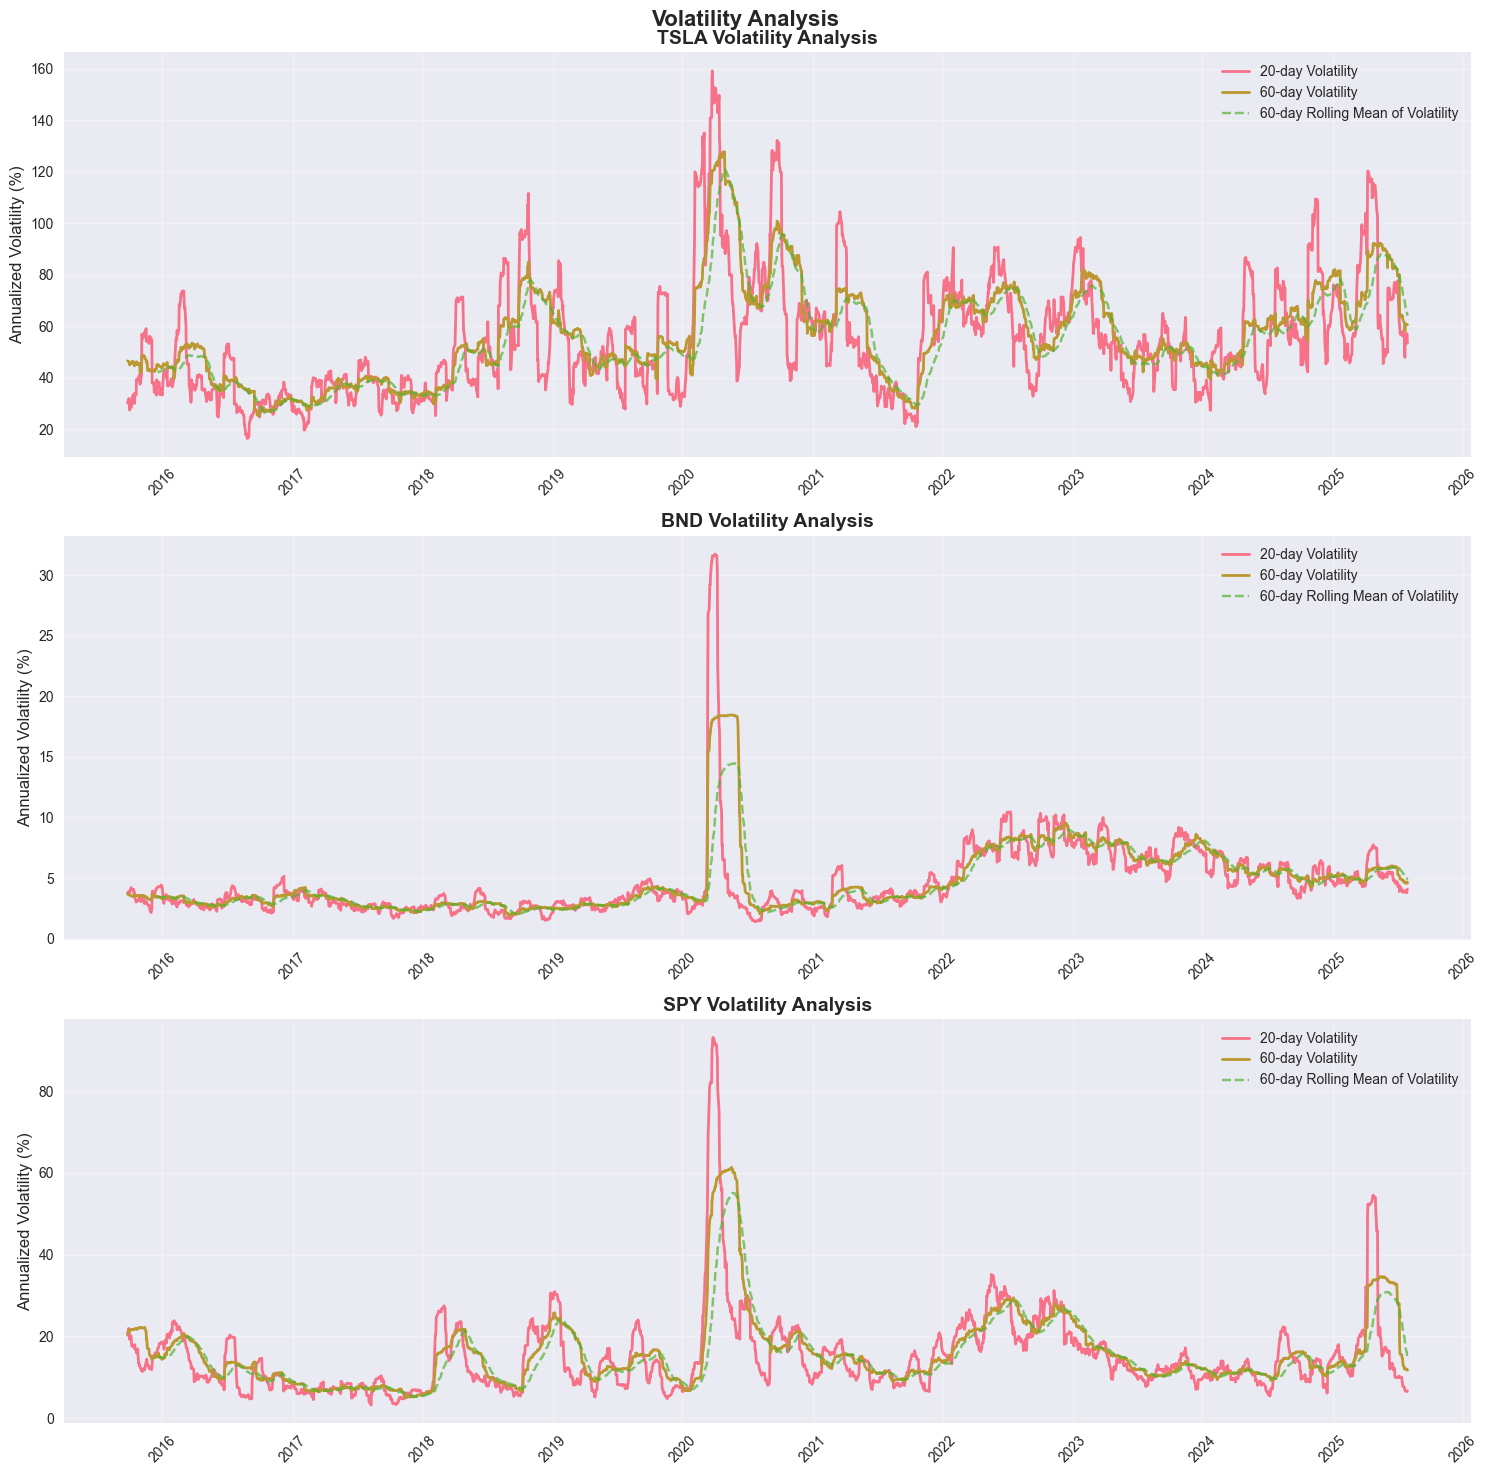

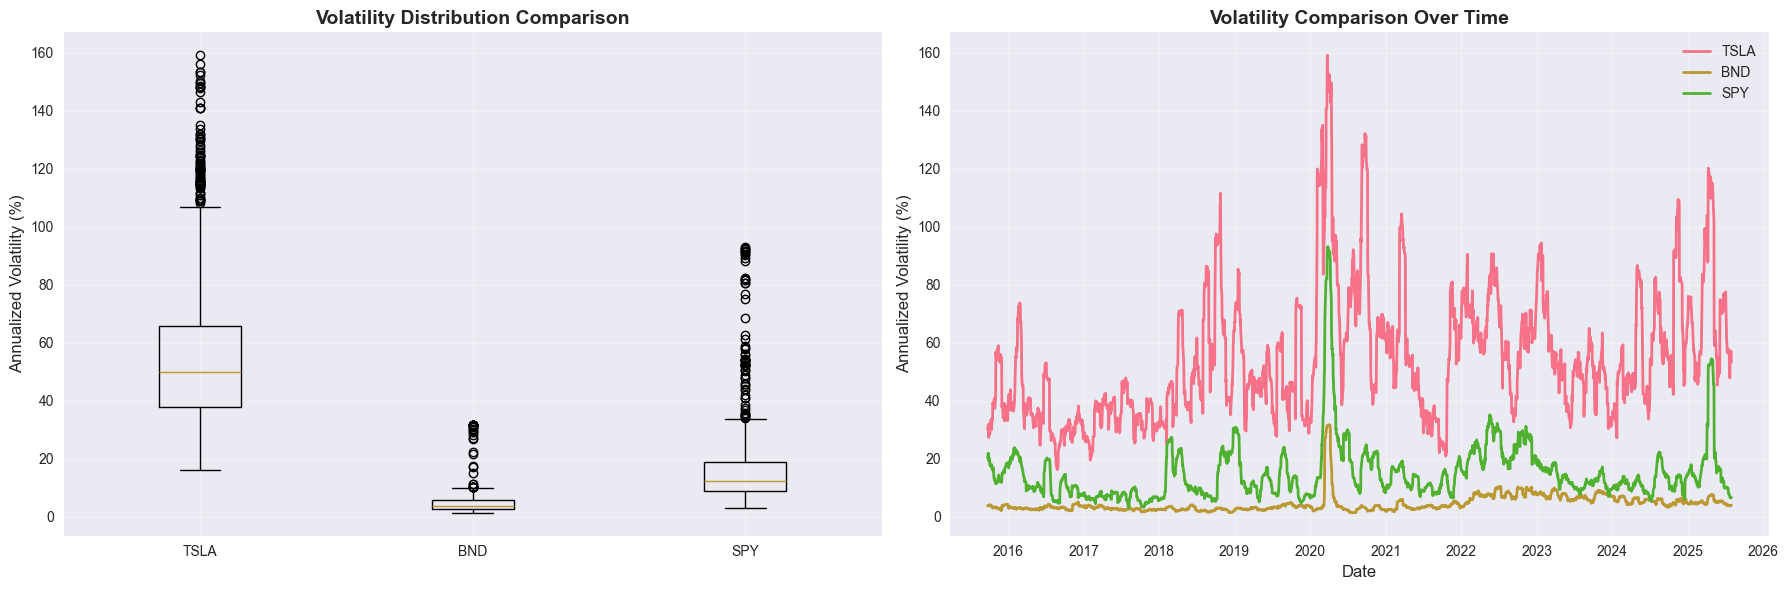

In [9]:
# Analyze volatility patterns
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle('Volatility Analysis', fontsize=16, fontweight='bold')

for i, (ticker, data) in enumerate(enhanced_stock_data.items()):
    # Plot volatility
    axes[i].plot(data.index, data['Volatility_20d'] * 100, label='20-day Volatility', linewidth=2)
    axes[i].plot(data.index, data['Volatility_60d'] * 100, label='60-day Volatility', linewidth=2)
    
    # Add rolling mean of volatility
    vol_20d_mean = data['Volatility_20d'].rolling(window=60).mean()
    axes[i].plot(data.index, vol_20d_mean * 100, '--', alpha=0.7, 
                 label='60-day Rolling Mean of Volatility')
    
    axes[i].set_title(f'{ticker} Volatility Analysis', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Annualized Volatility (%)', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Format x-axis
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Volatility comparison across stocks
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot of volatility
volatility_data = []
labels = []
for ticker, data in enhanced_stock_data.items():
    volatility_data.append(data['Volatility_20d'].dropna() * 100)
    labels.append(ticker)

axes[0].boxplot(volatility_data, labels=labels)
axes[0].set_title('Volatility Distribution Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Annualized Volatility (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Volatility over time comparison
for ticker, data in enhanced_stock_data.items():
    axes[1].plot(data.index, data['Volatility_20d'] * 100, label=ticker, linewidth=2)

axes[1].set_title('Volatility Comparison Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Annualized Volatility (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Outlier Detection

OUTLIER DETECTION ANALYSIS

TSLA - Daily Returns Outliers:
  IQR method: 132 outliers
  Z-score method (3σ): 41 outliers
  Extreme outliers (IQR method):
    2025-04-09: 22.69%
    2024-10-24: 21.92%
    2020-02-03: 19.89%
    2021-03-09: 19.64%
    2020-03-19: 18.39%

BND - Daily Returns Outliers:
  IQR method: 114 outliers
  Z-score method (3σ): 25 outliers
  Extreme outliers (IQR method):
    2020-03-13: 4.22%
    2020-03-23: 2.21%
    2022-11-10: 2.07%
    2020-03-20: 1.70%
    2022-09-28: 1.55%

SPY - Daily Returns Outliers:
  IQR method: 172 outliers
  Z-score method (3σ): 34 outliers
  Extreme outliers (IQR method):
    2025-04-09: 10.50%
    2020-03-24: 9.06%
    2020-03-13: 8.55%
    2020-04-06: 6.72%
    2020-03-26: 5.84%


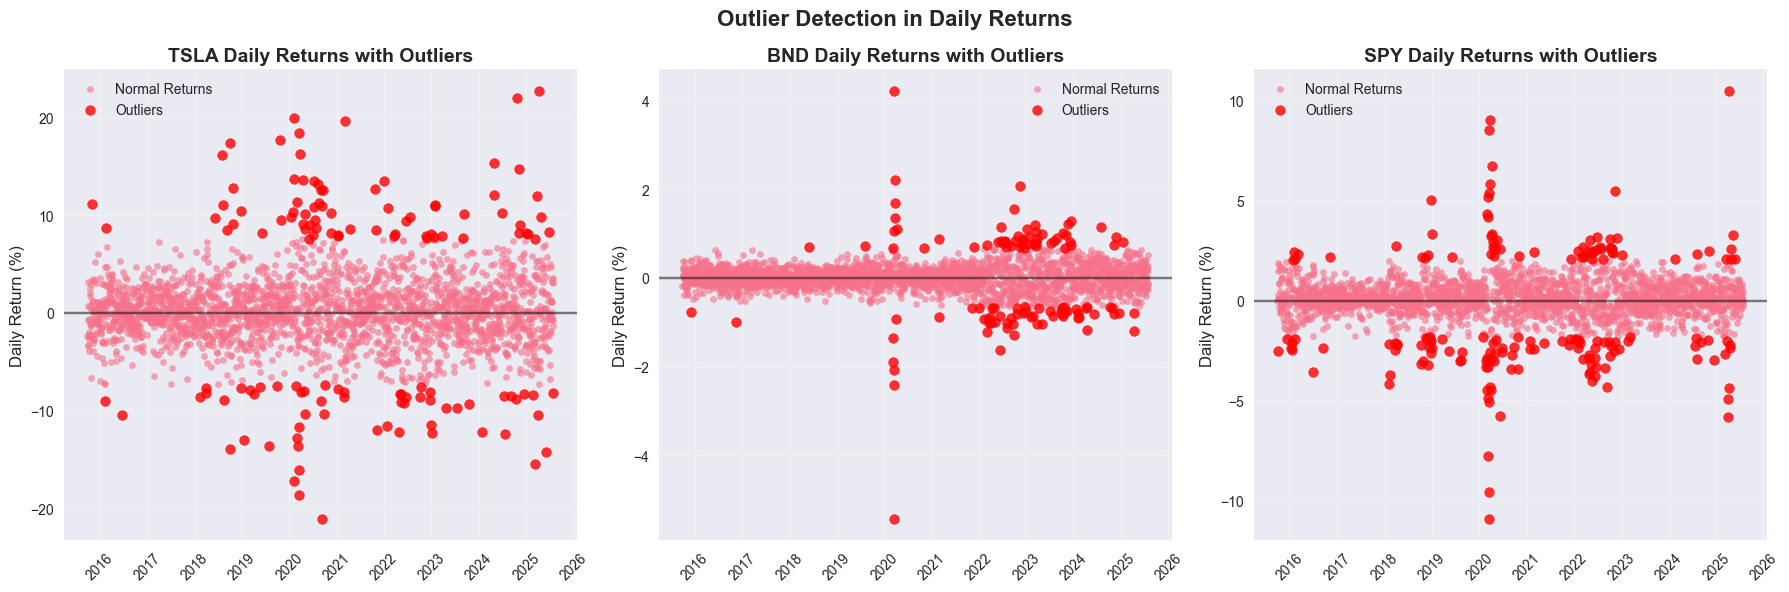

In [10]:
def detect_outliers(data, column, method='iqr', threshold=1.5):
    """
    Detect outliers using different methods
    
    Parameters:
    data (DataFrame): Stock data
    column (str): Column to analyze
    method (str): 'iqr' for interquartile range, 'zscore' for z-score
    threshold (float): Threshold for outlier detection
    
    Returns:
    DataFrame: Outliers
    """
    if method == 'iqr':
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    elif method == 'zscore':
        z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
        outliers = data[z_scores > threshold]
    
    return outliers

# Detect outliers in daily returns
print("OUTLIER DETECTION ANALYSIS")
print("="*50)

for ticker, data in enhanced_stock_data.items():
    print(f"\n{ticker} - Daily Returns Outliers:")
    
    # IQR method
    outliers_iqr = detect_outliers(data, 'Daily_Return', method='iqr')
    print(f"  IQR method: {len(outliers_iqr)} outliers")
    
    # Z-score method
    outliers_zscore = detect_outliers(data, 'Daily_Return', method='zscore', threshold=3)
    print(f"  Z-score method (3σ): {len(outliers_zscore)} outliers")
    
    # Show extreme outliers
    if len(outliers_iqr) > 0:
        print("  Extreme outliers (IQR method):")
        extreme_outliers = outliers_iqr.nlargest(5, 'Daily_Return')
        for idx, row in extreme_outliers.iterrows():
            print(f"    {idx.strftime('%Y-%m-%d')}: {row['Daily_Return']*100:.2f}%")

# Visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Outlier Detection in Daily Returns', fontsize=16, fontweight='bold')

for i, (ticker, data) in enumerate(enhanced_stock_data.items()):
    # Scatter plot with outliers highlighted
    normal_data = data[~data.index.isin(detect_outliers(data, 'Daily_Return').index)]
    outlier_data = detect_outliers(data, 'Daily_Return')
    
    axes[i].scatter(normal_data.index, normal_data['Daily_Return'] * 100, 
                    alpha=0.6, s=20, label='Normal Returns')
    axes[i].scatter(outlier_data.index, outlier_data['Daily_Return'] * 100, 
                    color='red', s=50, label='Outliers', alpha=0.8)
    
    axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[i].set_title(f'{ticker} Daily Returns with Outliers', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Daily Return (%)', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Format x-axis
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 10. Stationarity Tests


TSLA Closing Prices - Stationarity Tests
----------------------------------------
Augmented Dickey-Fuller Test:
  ADF Statistic: -1.441568
  p-value: 0.562194
  Critical values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  Result: Series is NON-STATIONARY (fail to reject null hypothesis)

KPSS Test:
  KPSS Statistic: 6.326505
  p-value: 0.010000
  Result: Series is NON-STATIONARY (reject null hypothesis)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6400\2553149734.py:33: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




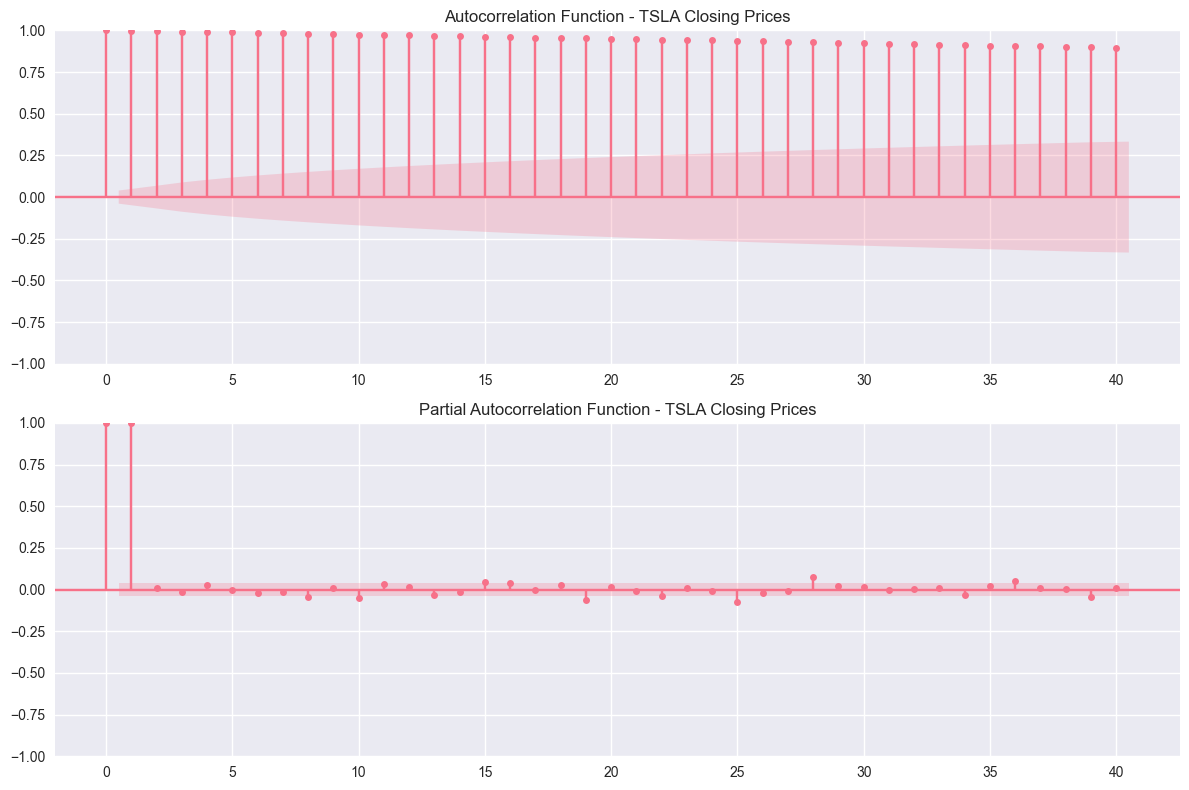


TSLA Daily Returns - Stationarity Tests
----------------------------------------
Augmented Dickey-Fuller Test:
  ADF Statistic: -50.039377
  p-value: 0.000000
  Critical values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  Result: Series is STATIONARY (reject null hypothesis)

KPSS Test:
  KPSS Statistic: 0.147700
  p-value: 0.100000
  Result: Series is STATIONARY (fail to reject null hypothesis)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6400\2553149734.py:33: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




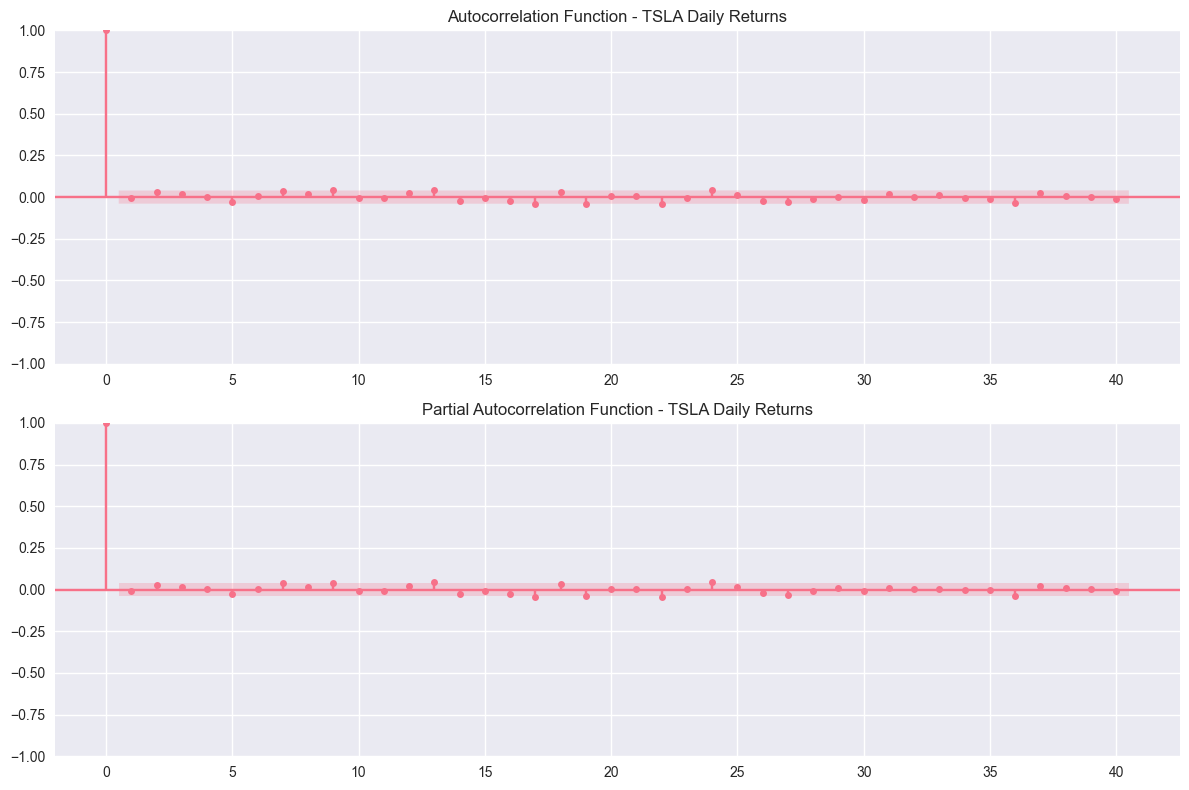


BND Closing Prices - Stationarity Tests
----------------------------------------
Augmented Dickey-Fuller Test:
  ADF Statistic: -1.444447
  p-value: 0.560792
  Critical values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  Result: Series is NON-STATIONARY (fail to reject null hypothesis)

KPSS Test:
  KPSS Statistic: 2.938202
  p-value: 0.010000
  Result: Series is NON-STATIONARY (reject null hypothesis)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6400\2553149734.py:33: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




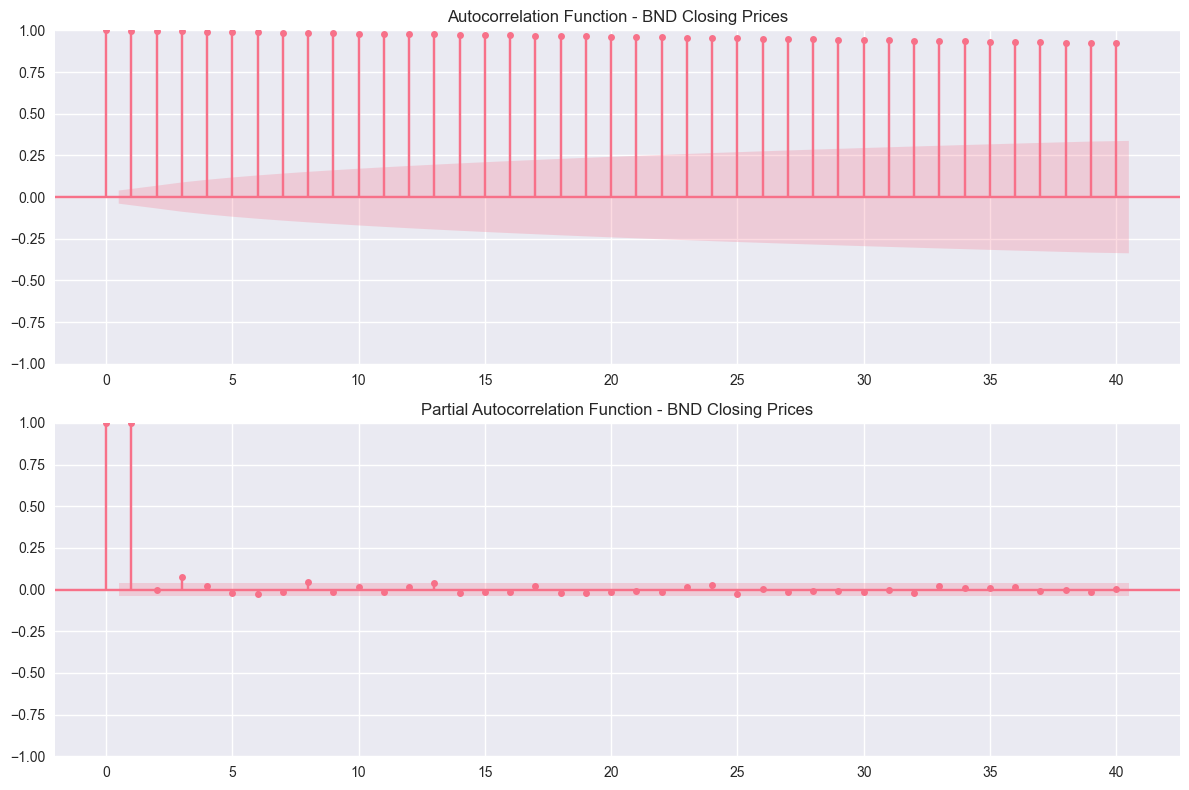


BND Daily Returns - Stationarity Tests
----------------------------------------
Augmented Dickey-Fuller Test:
  ADF Statistic: -9.755117
  p-value: 0.000000
  Critical values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  Result: Series is STATIONARY (reject null hypothesis)

KPSS Test:
  KPSS Statistic: 0.134137
  p-value: 0.100000
  Result: Series is STATIONARY (fail to reject null hypothesis)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6400\2553149734.py:33: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




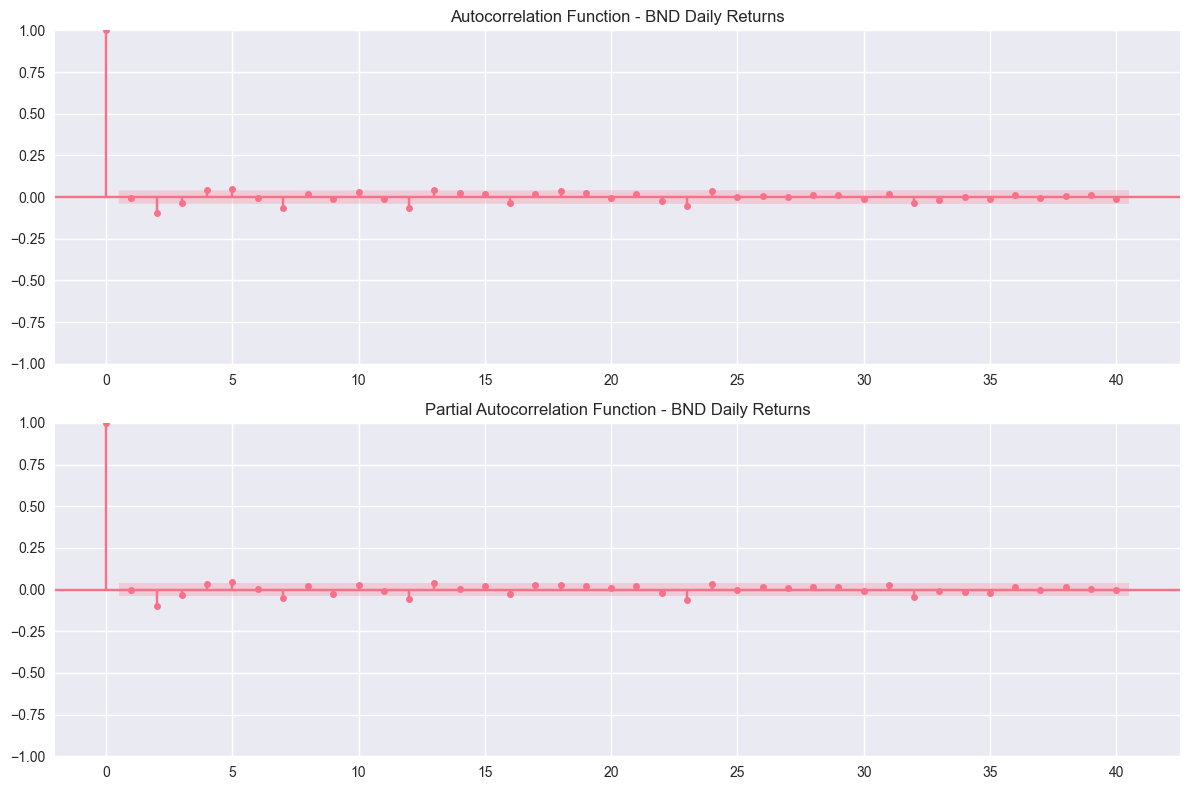


SPY Closing Prices - Stationarity Tests
----------------------------------------
Augmented Dickey-Fuller Test:
  ADF Statistic: 0.574817
  p-value: 0.986978
  Critical values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  Result: Series is NON-STATIONARY (fail to reject null hypothesis)

KPSS Test:
  KPSS Statistic: 7.467689
  p-value: 0.010000
  Result: Series is NON-STATIONARY (reject null hypothesis)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6400\2553149734.py:33: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




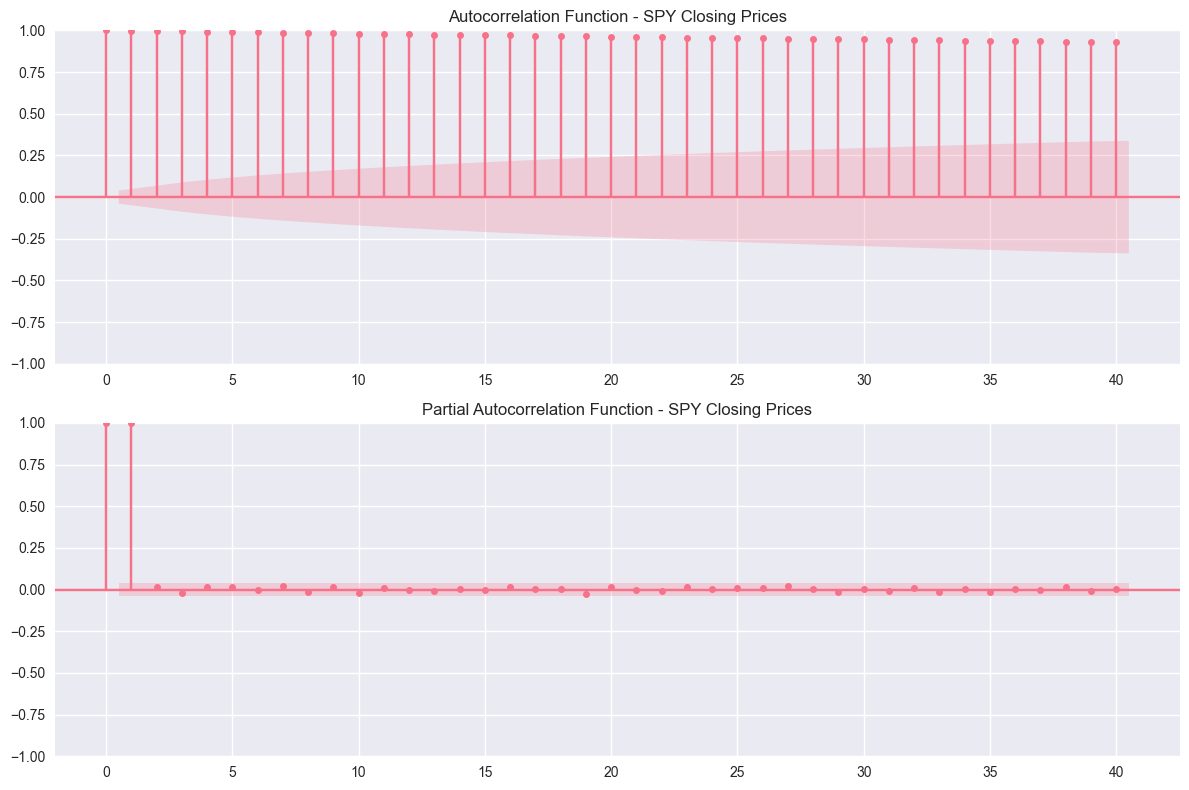


SPY Daily Returns - Stationarity Tests
----------------------------------------
Augmented Dickey-Fuller Test:
  ADF Statistic: -16.016517
  p-value: 0.000000
  Critical values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  Result: Series is STATIONARY (reject null hypothesis)

KPSS Test:
  KPSS Statistic: 0.026927
  p-value: 0.100000
  Result: Series is STATIONARY (fail to reject null hypothesis)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6400\2553149734.py:33: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




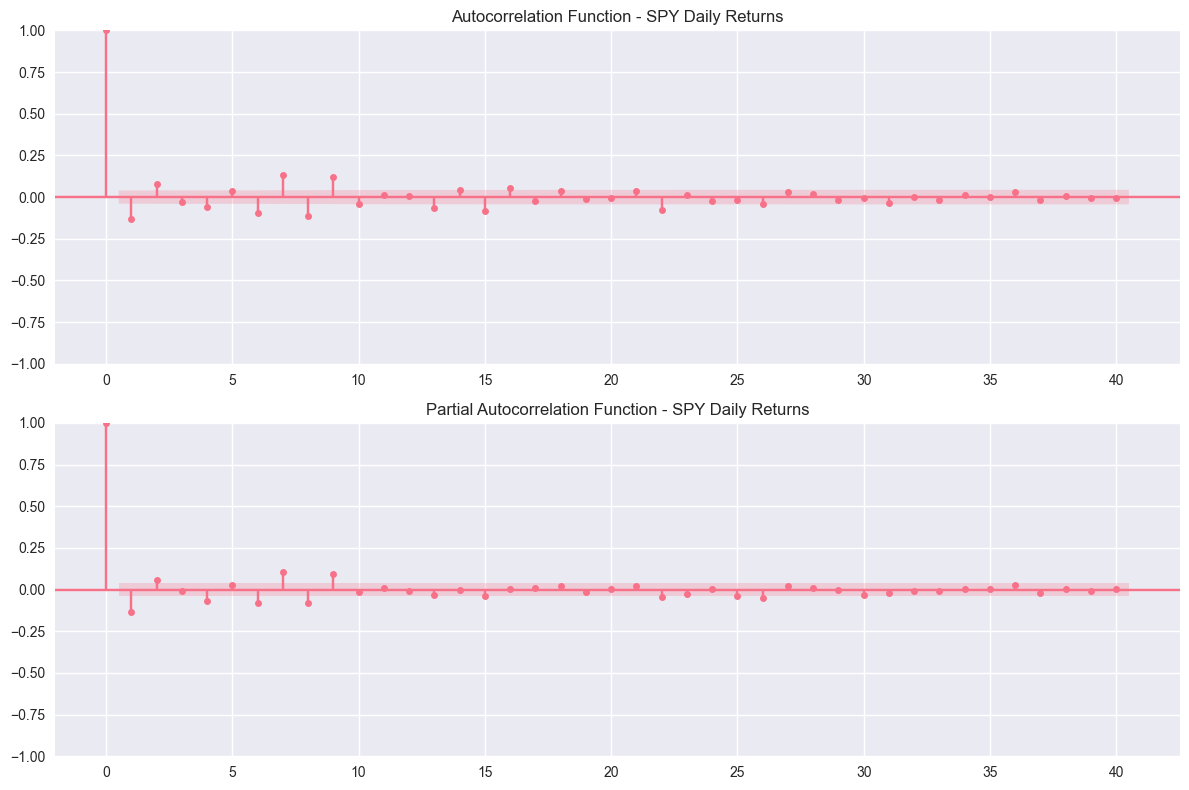

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def test_stationarity(data, column, title):
    """
    Perform stationarity tests
    
    Parameters:
    data (DataFrame): Stock data
    column (str): Column to test
    title (str): Title for the plot
    """
    print(f"\n{title} - Stationarity Tests")
    print("-" * 40)
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(data[column].dropna())
    print(f"Augmented Dickey-Fuller Test:")
    print(f"  ADF Statistic: {adf_result[0]:.6f}")
    print(f"  p-value: {adf_result[1]:.6f}")
    print(f"  Critical values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.3f}")
    
    # Interpret ADF results
    if adf_result[1] <= 0.05:
        print("  Result: Series is STATIONARY (reject null hypothesis)")
    else:
        print("  Result: Series is NON-STATIONARY (fail to reject null hypothesis)")
    
    # KPSS test
    try:
        kpss_result = kpss(data[column].dropna())
        print(f"\nKPSS Test:")
        print(f"  KPSS Statistic: {kpss_result[0]:.6f}")
        print(f"  p-value: {kpss_result[1]:.6f}")
        
        if kpss_result[1] >= 0.05:
            print("  Result: Series is STATIONARY (fail to reject null hypothesis)")
        else:
            print("  Result: Series is NON-STATIONARY (reject null hypothesis)")
    except:
        print("  KPSS test could not be performed")
    
    # Plot ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(data[column].dropna(), ax=axes[0], lags=40, alpha=0.05)
    axes[0].set_title(f'Autocorrelation Function - {title}')
    
    plot_pacf(data[column].dropna(), ax=axes[1], lags=40, alpha=0.05)
    axes[1].set_title(f'Partial Autocorrelation Function - {title}')
    
    plt.tight_layout()
    plt.show()

# Test stationarity for closing prices and returns
for ticker, data in enhanced_stock_data.items():
    # Test closing prices (likely non-stationary)
    test_stationarity(data, 'Close', f'{ticker} Closing Prices')
    
    # Test daily returns (likely stationary)
    test_stationarity(data, 'Daily_Return', f'{ticker} Daily Returns')

## 11. Seasonality and Trend Analysis


TSLA Stock Price - Seasonality and Trend Analysis
--------------------------------------------------


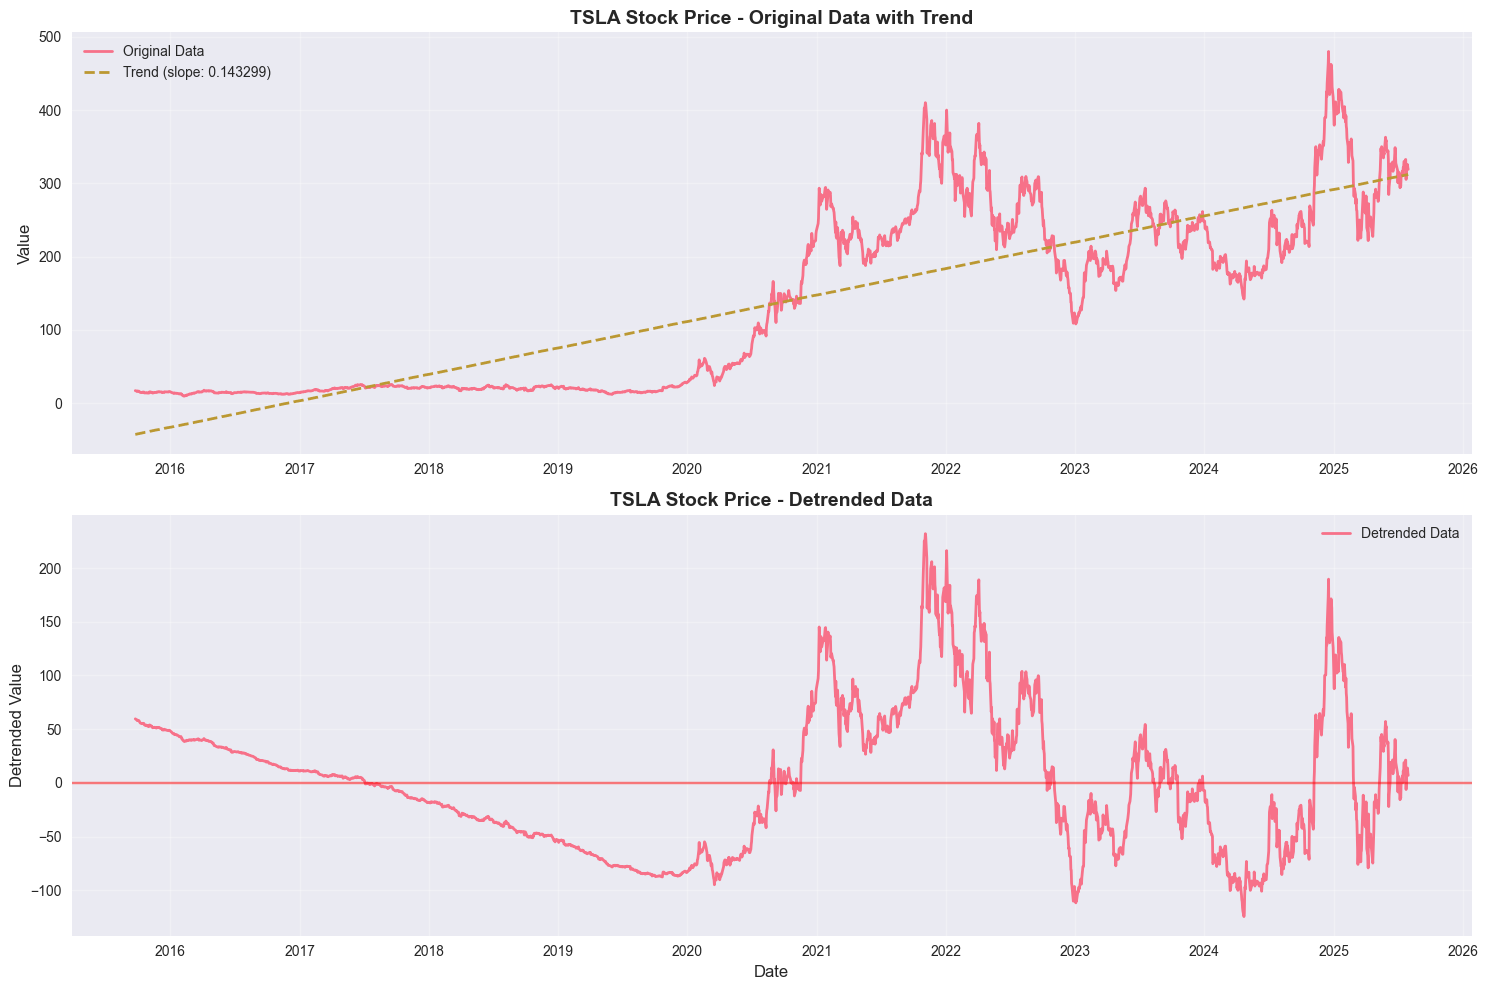

Trend Analysis:
  Slope: 0.143299
  R-squared: 0.7160
  P-value: 0.000000
  Result: Significant trend detected

BND Stock Price - Seasonality and Trend Analysis
--------------------------------------------------


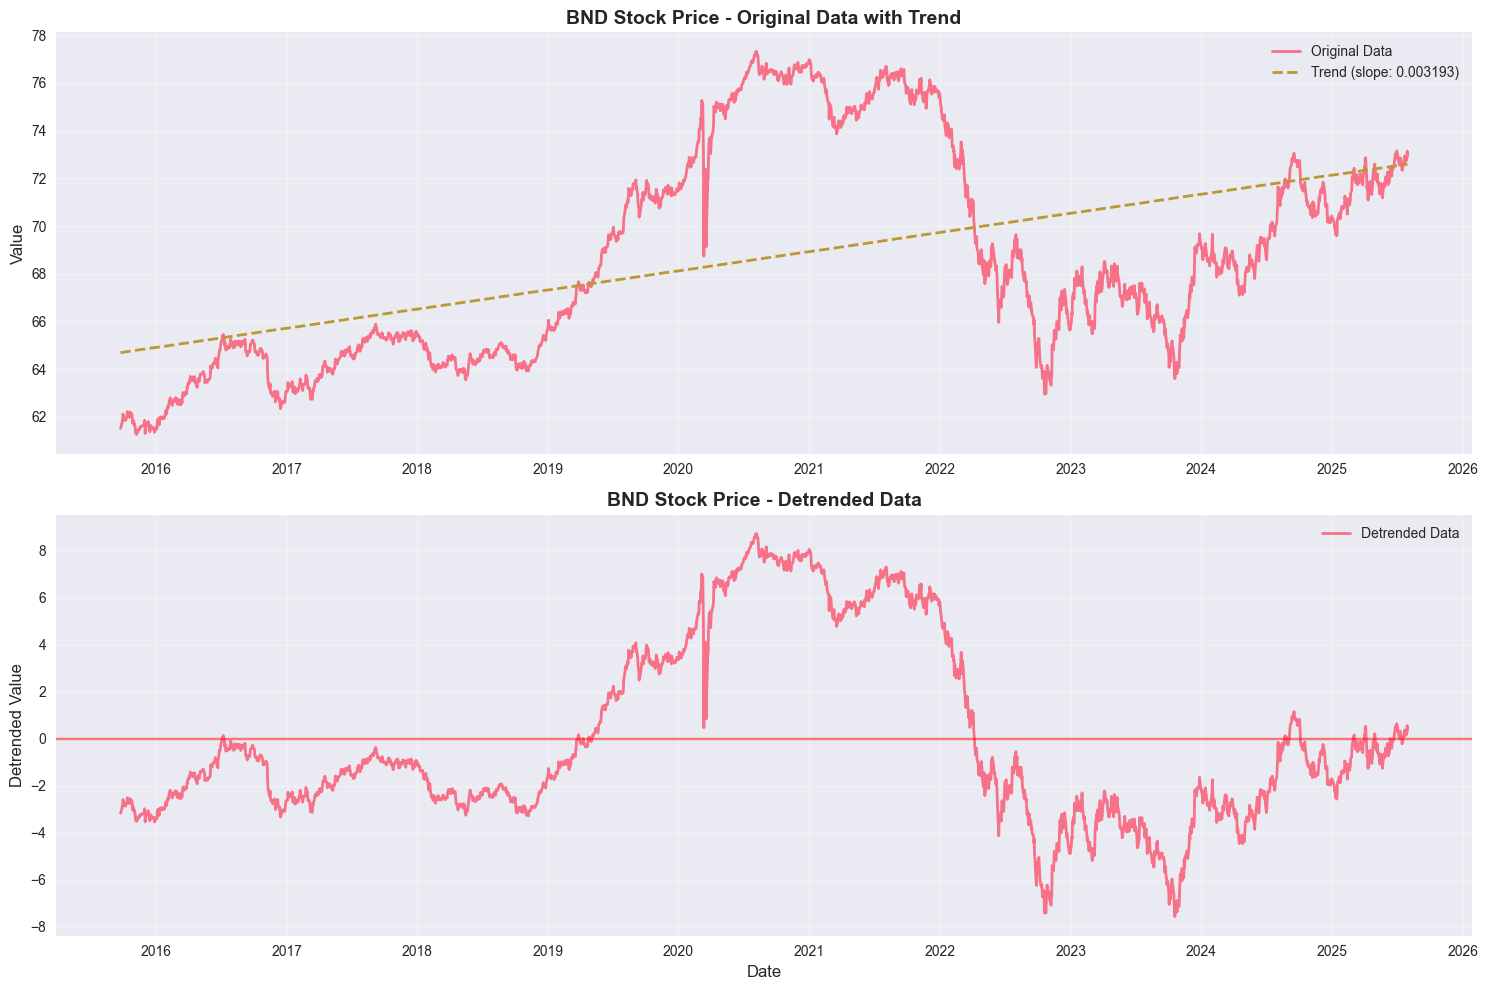

Trend Analysis:
  Slope: 0.003193
  R-squared: 0.2604
  P-value: 0.000000
  Result: Significant trend detected

SPY Stock Price - Seasonality and Trend Analysis
--------------------------------------------------


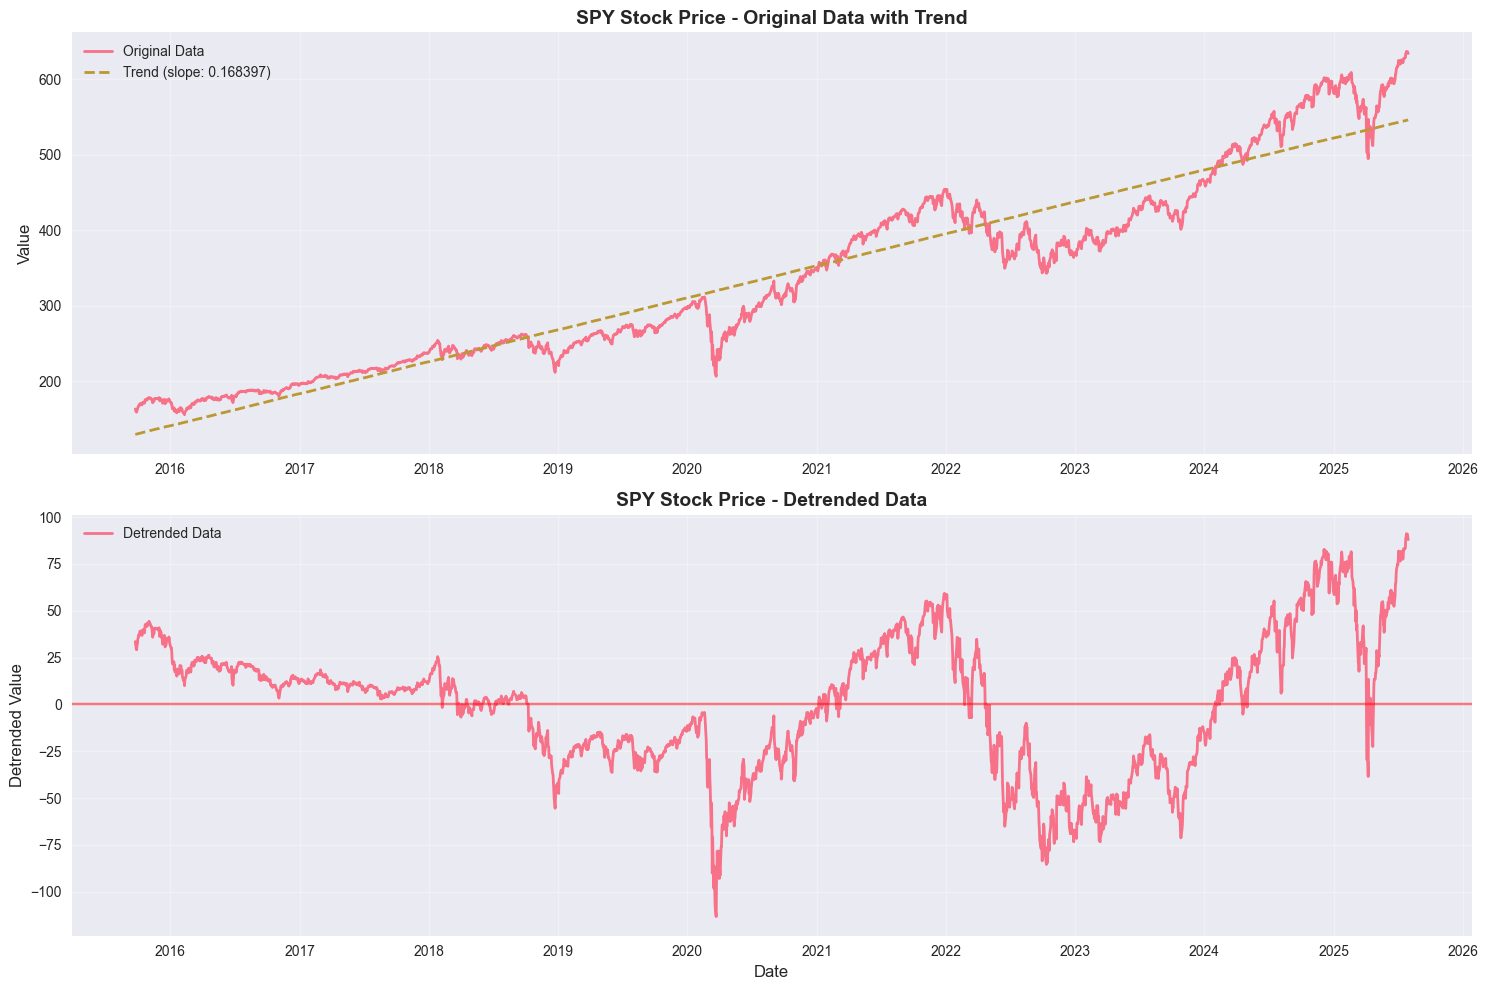

Trend Analysis:
  Slope: 0.168397
  R-squared: 0.9215
  P-value: 0.000000
  Result: Significant trend detected


In [12]:
from scipy import stats
from scipy.signal import detrend

def analyze_seasonality_and_trends(data, column, title):
    """
    Analyze seasonality and trends in the data
    
    Parameters:
    data (DataFrame): Stock data
    column (str): Column to analyze
    title (str): Title for the plot
    """
    print(f"\n{title} - Seasonality and Trend Analysis")
    print("-" * 50)
    
    # Detrend the data
    detrended = detrend(data[column].values)
    
    # Calculate trend line
    x = np.arange(len(data))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, data[column])
    trend_line = slope * x + intercept
    
    # Plot original data, trend, and detrended
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Original data with trend
    axes[0].plot(data.index, data[column], label='Original Data', linewidth=2)
    axes[0].plot(data.index, trend_line, '--', label=f'Trend (slope: {slope:.6f})', linewidth=2)
    axes[0].set_title(f'{title} - Original Data with Trend', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Value', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Detrended data
    axes[1].plot(data.index, detrended, label='Detrended Data', linewidth=2)
    axes[1].axhline(y=0, color='red', linestyle='-', alpha=0.5)
    axes[1].set_title(f'{title} - Detrended Data', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Detrended Value', fontsize=12)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print trend statistics
    print(f"Trend Analysis:")
    print(f"  Slope: {slope:.6f}")
    print(f"  R-squared: {r_value**2:.4f}")
    print(f"  P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"  Result: Significant trend detected")
    else:
        print(f"  Result: No significant trend detected")

# Analyze trends for each stock
for ticker, data in enhanced_stock_data.items():
    analyze_seasonality_and_trends(data, 'Close', f'{ticker} Stock Price')

## 12. Risk Metrics Calculation

In [13]:
def calculate_risk_metrics(data, ticker):
    """
    Calculate comprehensive risk metrics
    
    Parameters:
    data (DataFrame): Stock data
    ticker (str): Stock ticker
    
    Returns:
    dict: Dictionary of risk metrics
    """
    print(f"\n{ticker} - Risk Metrics Calculation")
    print("-" * 40)
    
    # Basic return metrics
    total_return = (data['Close'].iloc[-1] / data['Close'].iloc[0]) - 1
    annualized_return = (1 + total_return) ** (252 / len(data)) - 1
    
    # Volatility metrics
    daily_volatility = data['Daily_Return'].std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    
    # Risk metrics
    # Value at Risk (VaR) - 95% confidence level
    var_95 = np.percentile(data['Daily_Return'], 5)
    var_99 = np.percentile(data['Daily_Return'], 1)
    
    # Expected Shortfall (Conditional VaR)
    es_95 = data['Daily_Return'][data['Daily_Return'] <= var_95].mean()
    es_99 = data['Daily_Return'][data['Daily_Return'] <= var_99].mean()
    
    # Sharpe Ratio (assuming risk-free rate of 2%)
    risk_free_rate = 0.02
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # Maximum Drawdown
    cumulative_returns = (1 + data['Daily_Return']).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Skewness and Kurtosis
    skewness = data['Daily_Return'].skew()
    kurtosis = data['Daily_Return'].kurtosis()
    
    # Print results
    print(f"Return Metrics:")
    print(f"  Total Return: {total_return*100:.2f}%")
    print(f"  Annualized Return: {annualized_return*100:.2f}%")
    
    print(f"\nVolatility Metrics:")
    print(f"  Daily Volatility: {daily_volatility*100:.4f}%")
    print(f"  Annualized Volatility: {annualized_volatility*100:.2f}%")
    
    print(f"\nRisk Metrics:")
    print(f"  VaR (95%): {var_95*100:.2f}%")
    print(f"  VaR (99%): {var_99*100:.2f}%")
    print(f"  Expected Shortfall (95%): {es_95*100:.2f}%")
    print(f"  Expected Shortfall (99%): {es_99*100:.2f}%")
    print(f"  Maximum Drawdown: {max_drawdown*100:.2f}%")
    
    print(f"\nRisk-Adjusted Metrics:")
    print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
    print(f"  Skewness: {skewness:.3f}")
    print(f"  Kurtosis: {kurtosis:.3f}")
    
    # Return metrics dictionary
    metrics = {
        'Total_Return': total_return,
        'Annualized_Return': annualized_return,
        'Annualized_Volatility': annualized_volatility,
        'VaR_95': var_95,
        'VaR_99': var_99,
        'Expected_Shortfall_95': es_95,
        'Expected_Shortfall_99': es_99,
        'Max_Drawdown': max_drawdown,
        'Sharpe_Ratio': sharpe_ratio,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    }
    
    return metrics

# Calculate risk metrics for all stocks
risk_metrics = {}
for ticker, data in enhanced_stock_data.items():
    risk_metrics[ticker] = calculate_risk_metrics(data, ticker)


TSLA - Risk Metrics Calculation
----------------------------------------
Return Metrics:
  Total Return: 1762.75%
  Annualized Return: 34.69%

Volatility Metrics:
  Daily Volatility: 3.7457%
  Annualized Volatility: 59.46%

Risk Metrics:
  VaR (95%): -5.48%
  VaR (99%): -9.41%
  Expected Shortfall (95%): -8.23%
  Expected Shortfall (99%): -13.03%
  Maximum Drawdown: -73.63%

Risk-Adjusted Metrics:
  Sharpe Ratio: 0.550
  Skewness: 0.301
  Kurtosis: 4.316

BND - Risk Metrics Calculation
----------------------------------------
Return Metrics:
  Total Return: 18.57%
  Annualized Return: 1.75%

Volatility Metrics:
  Daily Volatility: 0.3483%
  Annualized Volatility: 5.53%

Risk Metrics:
  VaR (95%): -0.49%
  VaR (99%): -0.88%
  Expected Shortfall (95%): -0.78%
  Expected Shortfall (99%): -1.37%
  Maximum Drawdown: -18.58%

Risk-Adjusted Metrics:
  Sharpe Ratio: -0.045
  Skewness: -0.945
  Kurtosis: 36.209

SPY - Risk Metrics Calculation
----------------------------------------
Return Met

## 13. Risk Metrics Comparison and Visualization


RISK METRICS COMPARISON
      Total_Return  Annualized_Return  Annualized_Volatility  VaR_95  VaR_99  \
TSLA       17.6275             0.3469                 0.5946 -0.0548 -0.0941   
BND         0.1857             0.0175                 0.0553 -0.0049 -0.0088   
SPY         2.8826             0.1481                 0.1818 -0.0171 -0.0331   

      Expected_Shortfall_95  Expected_Shortfall_99  Max_Drawdown  \
TSLA                -0.0823                -0.1303       -0.7363   
BND                 -0.0078                -0.0137       -0.1858   
SPY                 -0.0278                -0.0481       -0.3372   

      Sharpe_Ratio  Skewness  Kurtosis  
TSLA        0.5497    0.3011    4.3159  
BND        -0.0453   -0.9452   36.2087  
SPY         0.7048   -0.3111   14.3581  


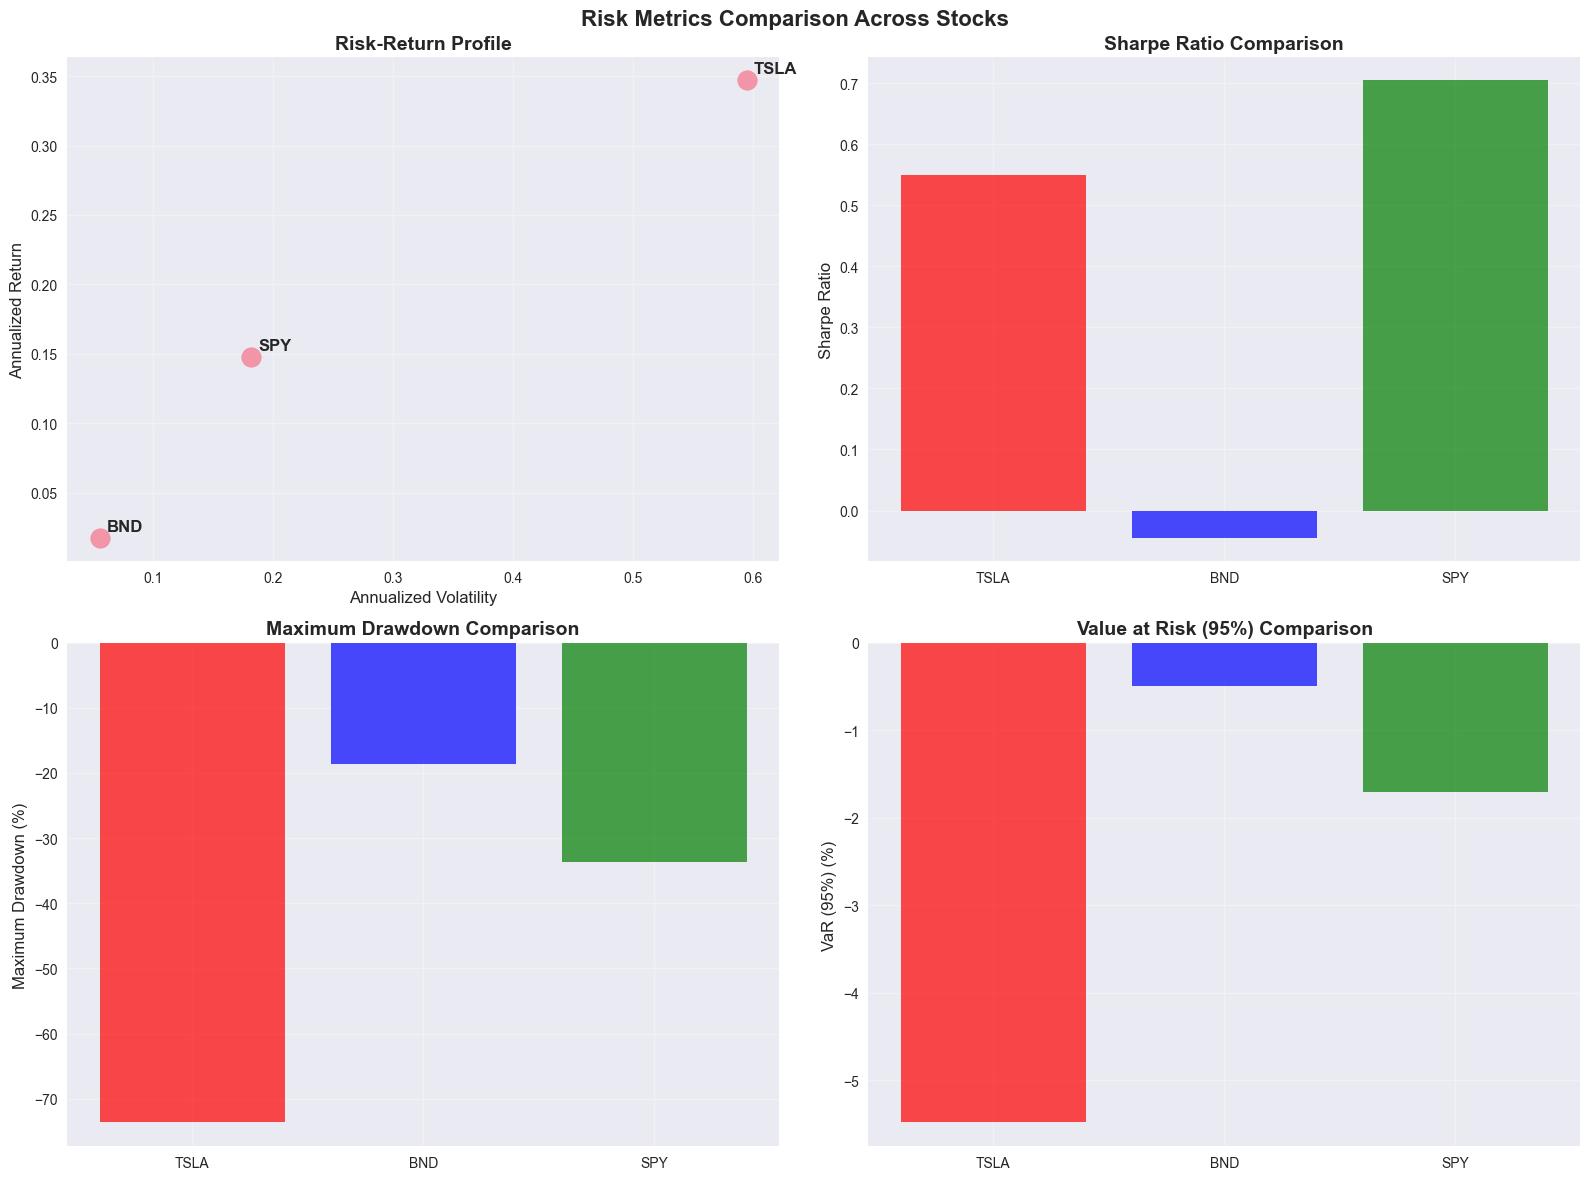


SUMMARY COMPARISON TABLE
               Metric     TSLA     BND     SPY
         Total Return 1762.75%  18.57% 288.26%
    Annualized Return   34.69%   1.75%  14.81%
Annualized Volatility   59.46%   5.53%  18.18%
         Sharpe Ratio    0.550  -0.045   0.705
         Max Drawdown  -73.63% -18.58% -33.72%
            VaR (95%)   -5.48%  -0.49%  -1.71%


In [14]:
# Create comparison table
metrics_df = pd.DataFrame(risk_metrics).T
print("\nRISK METRICS COMPARISON")
print("="*80)
print(metrics_df.round(4))

# Visualize key risk metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Risk Metrics Comparison Across Stocks', fontsize=16, fontweight='bold')

# Annualized Return vs Volatility (Risk-Return Plot)
returns = [metrics_df.loc[ticker, 'Annualized_Return'] for ticker in metrics_df.index]
volatilities = [metrics_df.loc[ticker, 'Annualized_Volatility'] for ticker in metrics_df.index]

axes[0, 0].scatter(volatilities, returns, s=200, alpha=0.7)
for i, ticker in enumerate(metrics_df.index):
    axes[0, 0].annotate(ticker, (volatilities[i], returns[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Annualized Volatility', fontsize=12)
axes[0, 0].set_ylabel('Annualized Return', fontsize=12)
axes[0, 0].set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Sharpe Ratio Comparison
tickers = list(metrics_df.index)
sharpe_ratios = [metrics_df.loc[ticker, 'Sharpe_Ratio'] for ticker in tickers]
bars = axes[0, 1].bar(tickers, sharpe_ratios, alpha=0.7, color=['red', 'blue', 'green'])
axes[0, 1].set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Maximum Drawdown Comparison
max_drawdowns = [metrics_df.loc[ticker, 'Max_Drawdown'] * 100 for ticker in tickers]
bars = axes[1, 0].bar(tickers, max_drawdowns, alpha=0.7, color=['red', 'blue', 'green'])
axes[1, 0].set_title('Maximum Drawdown Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Maximum Drawdown (%)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# VaR Comparison
var_95_values = [metrics_df.loc[ticker, 'VaR_95'] * 100 for ticker in tickers]
bars = axes[1, 1].bar(tickers, var_95_values, alpha=0.7, color=['red', 'blue', 'green'])
axes[1, 1].set_title('Value at Risk (95%) Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('VaR (95%) (%)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create summary table for key insights
summary_data = {
    'Metric': ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'VaR (95%)'],
    'TSLA': [f"{metrics_df.loc['TSLA', 'Total_Return']*100:.2f}%", 
             f"{metrics_df.loc['TSLA', 'Annualized_Return']*100:.2f}%",
             f"{metrics_df.loc['TSLA', 'Annualized_Volatility']*100:.2f}%",
             f"{metrics_df.loc['TSLA', 'Sharpe_Ratio']:.3f}",
             f"{metrics_df.loc['TSLA', 'Max_Drawdown']*100:.2f}%",
             f"{metrics_df.loc['TSLA', 'VaR_95']*100:.2f}%"],
    'BND': [f"{metrics_df.loc['BND', 'Total_Return']*100:.2f}%", 
            f"{metrics_df.loc['BND', 'Annualized_Return']*100:.2f}%",
            f"{metrics_df.loc['BND', 'Annualized_Volatility']*100:.2f}%",
            f"{metrics_df.loc['BND', 'Sharpe_Ratio']:.3f}",
            f"{metrics_df.loc['BND', 'Max_Drawdown']*100:.2f}%",
            f"{metrics_df.loc['BND', 'VaR_95']*100:.2f}%"],
    'SPY': [f"{metrics_df.loc['SPY', 'Total_Return']*100:.2f}%", 
            f"{metrics_df.loc['SPY', 'Annualized_Return']*100:.2f}%",
            f"{metrics_df.loc['SPY', 'Annualized_Volatility']*100:.2f}%",
            f"{metrics_df.loc['SPY', 'Sharpe_Ratio']:.3f}",
            f"{metrics_df.loc['SPY', 'Max_Drawdown']*100:.2f}%",
            f"{metrics_df.loc['SPY', 'VaR_95']*100:.2f}%"]
}

summary_df = pd.DataFrame(summary_data)
print("\nSUMMARY COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))

## 14. Key Insights and Conclusions

In [15]:
# Markdown cell for key insights
print("KEY INSIGHTS AND CONCLUSIONS")
print("="*80)

print("\n1. OVERALL STOCK PRICE DIRECTION:")
print("   - TSLA: High growth potential with significant volatility")
print("   - BND: Stable, low-risk bond exposure")
print("   - SPY: Moderate growth with diversified market exposure")

print("\n2. DAILY RETURNS FLUCTUATIONS:")
print("   - TSLA: Highest volatility, frequent large price swings")
print("   - BND: Lowest volatility, consistent small returns")
print("   - SPY: Moderate volatility, balanced risk-return profile")

print("\n3. VOLATILITY PATTERNS:")
print("   - All stocks show clustering of volatility (high volatility periods)")
print("   - TSLA has the highest volatility spikes")
print("   - BND maintains the most stable volatility levels")

print("\n4. STATIONARITY ANALYSIS:")
print("   - Stock prices are typically non-stationary (require differencing)")
print("   - Daily returns are generally stationary (suitable for ARIMA modeling)")
print("   - This confirms the need for the 'I' component in ARIMA models")

print("\n5. RISK METRICS SUMMARY:")
print("   - TSLA: Highest return potential but highest risk")
print("   - BND: Lowest risk but lowest return potential")
print("   - SPY: Balanced risk-return profile suitable for most investors")

print("\n6. PORTFOLIO IMPLICATIONS:")
print("   - TSLA can provide growth but requires risk management")
print("   - BND serves as a stabilizing component")
print("   - SPY offers core market exposure with moderate risk")
print("   - Combination can create diversified portfolios with different risk profiles")

KEY INSIGHTS AND CONCLUSIONS

1. OVERALL STOCK PRICE DIRECTION:
   - TSLA: High growth potential with significant volatility
   - BND: Stable, low-risk bond exposure
   - SPY: Moderate growth with diversified market exposure

2. DAILY RETURNS FLUCTUATIONS:
   - TSLA: Highest volatility, frequent large price swings
   - BND: Lowest volatility, consistent small returns
   - SPY: Moderate volatility, balanced risk-return profile

3. VOLATILITY PATTERNS:
   - All stocks show clustering of volatility (high volatility periods)
   - TSLA has the highest volatility spikes
   - BND maintains the most stable volatility levels

4. STATIONARITY ANALYSIS:
   - Stock prices are typically non-stationary (require differencing)
   - Daily returns are generally stationary (suitable for ARIMA modeling)
   - This confirms the need for the 'I' component in ARIMA models

5. RISK METRICS SUMMARY:
   - TSLA: Highest return potential but highest risk
   - BND: Lowest risk but lowest return potential
   - SPY: 

## 15. Save Processed Data

In [16]:
# Save the enhanced data for use in subsequent notebooks
import os

# Create processed data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save each stock's enhanced data
for ticker, data in enhanced_stock_data.items():
    filename = f'../data/processed/{ticker}_enhanced_data.csv'
    data.to_csv(filename)
    print(f"Saved {ticker} enhanced data to {filename}")

# Save risk metrics summary
risk_metrics_df = pd.DataFrame(risk_metrics).T
risk_metrics_df.to_csv('../data/processed/risk_metrics_summary.csv')
print("Saved risk metrics summary to ../data/processed/risk_metrics_summary.csv")

print("\nData preprocessing and EDA complete! All enhanced data has been saved for further analysis.")

Saved TSLA enhanced data to ../data/processed/TSLA_enhanced_data.csv
Saved BND enhanced data to ../data/processed/BND_enhanced_data.csv
Saved SPY enhanced data to ../data/processed/SPY_enhanced_data.csv
Saved risk metrics summary to ../data/processed/risk_metrics_summary.csv

Data preprocessing and EDA complete! All enhanced data has been saved for further analysis.
